In [1]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('merged_df.csv')
df.head()

,Unnamed: 0,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,...,total load forecast,total load actual,price day ahead,price actual,temp,humidity,pressure,wind_speed,rain_1h,clouds_all
0,0,2014-12-31 23:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,...,26118.0,25385.0,50.10,65.41,272.491463,82.4,1016.4,2.0,0.0,0.0
1,1,2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,...,24934.0,24382.0,48.10,64.92,272.512700,82.4,1016.2,2.0,0.0,0.0
2,2,2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,...,23515.0,22734.0,47.33,64.48,272.099137,82.0,1016.8,2.4,0.0,0.0
3,3,2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,...,22642.0,21286.0,42.27,59.32,272.089469,82.0,1016.6,2.4,0.0,0.0
4,4,2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,...,21785.0,20264.0,38.41,56.04,272.145900,82.0,1016.6,2.4,0.0,0.0


In [5]:

df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Convert time to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').set_index('time')


print(df.index.min(), "→", df.index.max())
print(df.shape)


2014-12-31 23:00:00 → 2018-12-31 22:00:00
(35064, 26)


In [6]:
import os
import random
import numpy as np

# Set global seed
SEED = 42

# Python & NumPy
random.seed(SEED)
np.random.seed(SEED)

# Simple RNN

In [7]:
# Select relevant columns
features = [
    'generation solar',
    'generation wind onshore',
    'generation nuclear',
    'temp',
    'humidity',
    'wind_speed'
]
target = 'total load actual'

# Drop missing rows just in case
data = df[features + [target]].dropna()


In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)


In [9]:
def create_sequences(df, target_col, window=24):
    X, y = [], []
    for i in range(window, len(df)):
        X.append(df.iloc[i-window:i].values)
        y.append(df[target_col].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df, target, window=24)

print("Input shape:", X.shape)
print("Target shape:", y.shape)


Input shape: (35040, 24, 7)
Target shape: (35040,)


In [10]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model_rnn = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.summary()

history = model_rnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,721 (26.25 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0158 - val_loss: 0.0015
Epoch 2/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 9.8559e-04 - val_loss: 8.5662e-04
Epoch 6/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.7004e-04 - val_loss: 7.3116e-04
Epoch 7/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 8.3223e-04 - val_loss: 7.9400e-04
Epoch 8/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.0819e-04 - val_loss: 7.2730e-04
Epoch 9/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.1431e-04 - val_loss: 9.2083e-04
Epoch 10/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 7.4590e-04 - val_loss: 7.4506e-04
Epoch 11/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 7.3300e-04 - val_loss: 7.746

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model_rnn.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = r2_score(y_test, y_pred)

print("\n📊 Simple RNN Performance:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📊 Simple RNN Performance:
MAE : 0.01
RMSE: 0.02
MAPE: 68.67%
R²  : 0.988


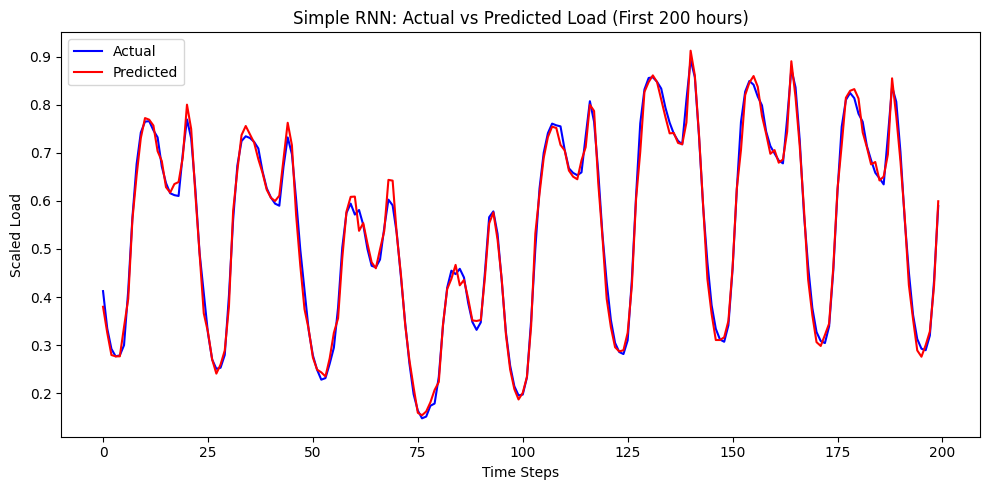

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Simple RNN: Actual vs Predicted Load (First 200 hours)')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Load')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Rebuild a DataFrame so the scaler can inverse transform
y_test_full = np.zeros((len(y_test), scaled_df.shape[1]))
y_test_full[:, scaled_df.columns.get_loc(target)] = y_test
y_test_inv = scaler.inverse_transform(y_test_full)[:, scaled_df.columns.get_loc(target)]

y_pred_full = np.zeros((len(y_pred), scaled_df.shape[1]))
y_pred_full[:, scaled_df.columns.get_loc(target)] = y_pred.flatten()
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, scaled_df.columns.get_loc(target)]

# Re-evaluate
mae  = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2   = r2_score(y_test_inv, y_pred_inv)

print("\n📊 Simple RNN (Inverse-Scaled) Performance:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")





📊 Simple RNN (Inverse-Scaled) Performance:
MAE : 324.13
RMSE: 500.77
MAPE: 1.14%
R²  : 0.988


# Overfitting?

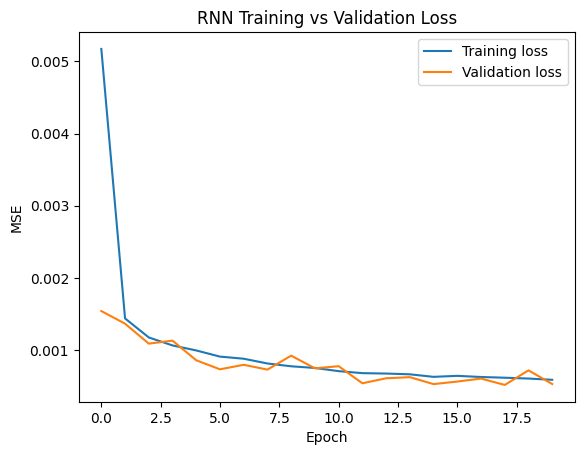

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('RNN Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


This is not overfitting.

The network is learning efficiently and converging after ~10–12 epochs.

The validation curve doesn’t diverge — instead, it mirrors the training curve almost exactly.

That matches your earlier performance metrics (MAE ≈ 324 MW, R² ≈ 0.988).